# 29、EM聚类：用EM算法对王者荣耀的英雄进行划分

由EM算法原理可知，EM算法相当于一个聚类框架，里面有不同的聚类模型，比如GMM高斯混合模型，或者HMM隐马科夫模型。其中我们需要理解的是EM的两个步骤，E步和M步：E步相当于通过初始化参数来估计隐含变量，M步是通过隐含变量来反推优化参数。最后通过EM步骤的迭代得到最终的模型参数。

先思考三个问题：
- 如何使用EM算法工具完成聚类？
- 什么情况下使用聚类算法？我们用聚类算法的任务目标是什么？
- 面对王者荣耀的英雄数据，EM算法能够帮助我们分析出什么？


## 如何 使用EM工具包

在Python中有第三方的EM算法工具包。由于EM算法是一个聚类框架，所以你需要明确你要用到的具体算法，比如采用的是GMM高斯混合模型，还是HMM隐马科夫模型。

这里我们主要使用GMM，在使用之前需要引入工具包：

In [ ]:
from sklearn.mixture import GaussianMixture

如何在sklearn中创建GMM聚类。

首先我们使用gmm = GaussianMixture(n_component=1, covariance_type='full', max_iter=100)来创建GMM聚类，其中有几个比较主要的参数（GMM类的构造参数比较多，下面列举的是主要的）：

1、n_components:即高斯混合模型的个数，也就是我们要聚类的个数，默认值为1.如果不指定n_components,最终的聚类结果都会为一个值。

2、covariance_type:代表的是协方差类型。一个高斯混合模型的分布是由均值向量和协方差矩阵决定的，所以协方差的类型也代表了不同的高斯混合模型的特征。协方差类型有4中取值：
- covariance_type=full,代表的是完全协方差，也就是元素都不为0；
- covariance_type=tied,代表相同的完全协方差；
- covariance_type=diag,代表对角协方差，也就是对角不为0，其余为0；
- covariance_type=spherical,代表球面协方差，非对角为0，对角完全相同，呈现球面的特征。

3、max_iter：代表最大的迭代次数，EM算法是有E步和M步迭代求得的最终模型参数，这里可以指定最大的迭代次数，默认值为100.

创建完成GMM聚类器之后，我们就可以传入数据让它进行迭代拟合。

我们使用fit函数，传入样本特征矩阵，模型会自动生成聚类器，然后使用prediction=qmm.predict(data)来对数据进行聚类，传入你想要进行聚类的数据，可以得到聚类的结果prediction。

我们可以看出来拟合训练和预测可以传入相同的特征矩阵，这是因为聚类是无监督学习，我们不需要事先指定聚类的结果，也无法基于先验的结果经验来进行学习。只要在训练过程中传入特征值矩阵，机器就会按照特征值矩阵生成聚类器，然后就可以使用这个聚类器进行聚类了。



## 如何用EM算法对王者荣耀数据进行分类

首先我们知道聚类的原理是“人以群分，物以类聚”。通过聚类算法可以把特征值相近的数据归为1类，不同的类之间的差异性比较大，这样就可以对原始数据进行降维。通过分成几个组（簇），来研究每个组之间的特性。或者我们可以把组（簇）的数量适当的提升，这样就可以找到可以相互替换的英雄，比如你的对手选择你擅长的英雄之后，你就可以选择另外一个英雄作为备选

先加载数据看一下数据长什么样子：

In [5]:
import pandas as pd
# 为了防止乱码，需要进行转码
data = pd.read_csv('./heros.csv', encoding='gb18030')
print(data.head())
#print(data.info)

    英雄  最大生命   生命成长  初始生命  最大法力  法力成长  初始法力  最高物攻    物攻成长  初始物攻  ...  最大每5秒回血  \
0  夏侯惇  7350  288.8  3307  1746    94   430   321  11.570   159  ...       98   
1  钟无艳  7000  275.0  3150  1760    95   430   318  11.000   164  ...       92   
2   张飞  8341  329.4  3450   100     0   100   301  10.570   153  ...      115   
3   牛魔  8476  352.8  3537  1926   104   470   273   8.357   156  ...      117   
4   吕布  7344  270.0  3564     0     0     0   343  12.360   170  ...       97   

   每5秒回血成长  初始每5秒回血  最大每5秒回蓝  每5秒回蓝成长  初始每5秒回蓝    最大攻速  攻击范围  主要定位 次要定位   
0    3.357       51       37    1.571       15  28.00%    近战    坦克    战士  
1    3.143       48       37    1.571       15  14.00%    近战    战士    坦克  
2    4.143       57        5    0.000        5  14.00%    近战    坦克    辅助  
3    4.214       58       42    1.786       17  14.00%    近战    坦克    辅助  
4    3.071       54        0    0.000        0  14.00%    近战    战士    坦克  

[5 rows x 23 columns]


直接上截图：
![](数据预览.png)

这里收集了69名英雄的20个特征属性，这些属性分别为最大生命、生命成长、初始生命、最大法力、法力成长、初始法力、最高物攻、物攻成长、初始物攻、最大物防、物防成长、初始物防、最大每5秒回血、每5秒回血成长、初始每5秒回血、最大每5秒回蓝、每5秒回蓝成长、初始每5秒回蓝、最大攻速和攻击范围等。

现在我们需要对王者荣耀的英雄数据进行聚类，可以先设定项目流程：
![](EM聚类流程.jpg)

1、首先我们需要加载数据资源；

2、在准备阶段，我们需要对数据进行探索，包括采用数据可视化技术，让我们对英雄属性以及这些属性之间的关系理解更加深刻，然后对数据的质量进行评估，是否进行数据清洗，随后进行特征选择方便后续的聚类算法；

3、聚类阶段：选择合适的聚类模型，这里我们选择GMM高斯混合模型进行聚类，并输出聚类结果，对结果进行分析。

编写代码如下所示：

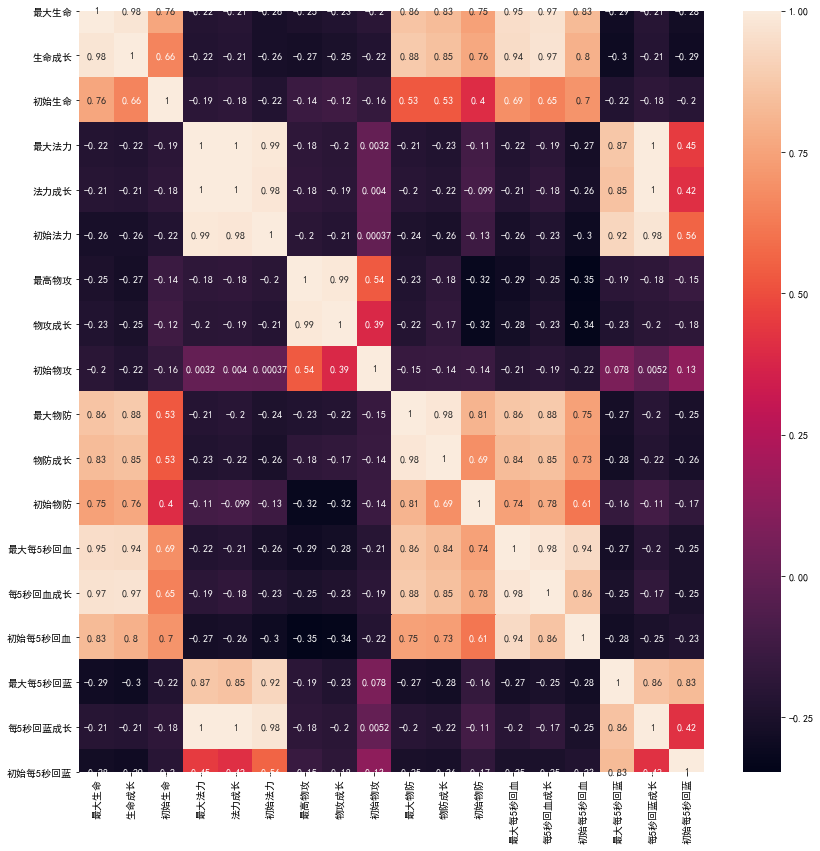

[ 7 17  6  2 26 26 13  6 29  5 11  5  2 17 21 11 24  2  3 25 15  4 25  9
  9  9 25 16 27  1 17  1  1 27  1  1 27  8 19 20  1 27 27  1  1 20  5 19
  5 27 10  0  3 14 14  7  7  0 22  3  7 23 12  7 18  0  0 28 16]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# -*- coding:utf-8 -*-
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
# 使用GMM高斯混合模型进行聚类
from sklearn.mixture import GaussianMixture
# 使用标准化正态分布进行数据规范化
from sklearn.preprocessing import StandardScaler

# 数据加载，避免中文乱码问题
data_ori = pd.read_csv('./heros.csv', encoding='gb18030')
# 特征值选择
features = [u'最大生命',u'生命成长',u'初始生命',u'最大法力',u'法力成长',u'初始法力',u'最高物攻',
            u'物攻成长',u'初始物攻',u'最大物防',u'物防成长',u'初始物防',u'最大每5秒回血',u'每5秒回血成长',
            u'初始每5秒回血',u'最大每5秒回蓝',u'每5秒回蓝成长',u'初始每5秒回蓝',u'最大攻速',u'攻击范围']
# 选取特征值数据
data = data_ori[features]

# 对英雄属性之间的关系进行可视化
# 设置plt正确显示中文，
plt.rcParams['font.sans-serif'] = ['simhei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
# 使用热力图来进行显示features_mean 字段之间的相关性
corr = data[features].corr()
plt.figure(figsize=(14,14))
# annot=True 显示每个方格的数据
sns.heatmap(corr, annot=True)
plt.show(sns)

# 相关性大的属性保留一个，因此可以对属性进行降维
features_remain = [u'最大生命',u'初始生命',u'最大法力',u'最高物攻',
            u'初始物攻',u'最大物防',u'初始物防',u'最大每5秒回血',
            u'最大每5秒回蓝',u'初始每5秒回蓝',u'最大攻速',u'攻击范围']
data = data_ori[features_remain]
# 处理最大攻速的百分号和攻击范围的近程和远程
# 这列会产生一个使用链式索引的警告:https://www.jianshu.com/p/72274ccb647a
data[u'最大攻速'] = data[u'最大攻速'].apply(lambda x: float(x.strip('%'))/100)
data[u'攻击范围'] = data[u'攻击范围'].map({'远程':1,'近战':0})
# 采用Z-Score规范化数据，保证每个特征维度的数据均值为0，方差为1
ss = StandardScaler()
data = ss.fit_transform(data)
# 构造 GMM 聚类
gmm = GaussianMixture(n_components=30, covariance_type='full')
gmm.fit(data)
# 训练数据
prediction = gmm.predict(data)
print(prediction)
# 将分组结果输出到CSV文件中
data_ori.insert(0, '分组', prediction)
data_ori.to_csv('./hero_out.csv', index=False, sep=',', encoding='gb18030')

上面输出的列表和输出的聚类结果文件hero_out.csv中的分组那一列的数据数对应上的.

简单讲解下程序的几个模块：

### 关于引用包

首先我们会使用到DataFrame数据结构来保存读取的数据，租后的聚类结果会写入到CSV文件中，因此会用到pandas和CSV工具包。另外我们需要对数据进行可视化，采用热力图展属性之间的相关性，这里使用到matplotlib.pyplot和seaborn工具包。在数据规范化中我们使用到了Z-Score规范化，用到了StandardScaler类，最后我们还会用到sklearn中的GaussianMixture类进行聚类。

### 数据可是化的探索

我们将20个英雄属性之间的关系用热力图呈现出来，中间的数字代表两个属性之间的关系系数，最大值为1，代表完全正相关，关系系数越大代表相关性就越大。从图中我们看出来“最大生命” “生命成长”和“初始生命”这三个属性的相关性大，我们只需要保留住一个属性即可。同理我们也可以对其他的相关性大的属性进行筛选，保留一个。在代码中使用到了features_remain数组保留了特征选择的属性，这样就将原本的20个属性降维到13个属性。

### 关于数据规范化
我们能看到“最大攻速”这个属性值是百分数，不适合用做矩阵运算，因此我们需要将百分数转化为小数。我们也看到“攻击范围”这个字段的取值为远程或者近战，也不适合矩阵运算，我们将取值做个映射，用1代表远程，0代表近战。然后采用Z-Score规范化，对特征矩阵进行规范化。

### 在聚类阶段
我们采用了GMM高斯混合模型，并将结果输出到CSV文件中。

截取部分的分组结果如下所示：


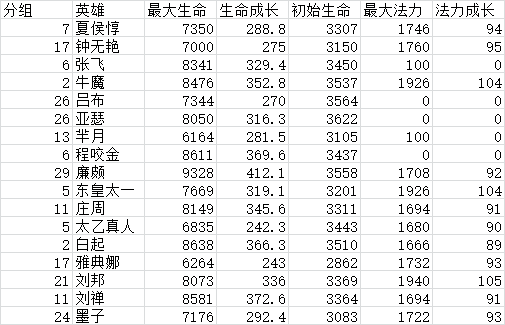

从上面的图片可以看到夏侯惇自成一族（其实后面还有数据），钟无艳和雅典娜一组，张飞和程咬金一组，牛魔和白起一组等等。聚类的特点是相同的类别之间的属性值很相近，不同类别的属性值差异大。因此如果你擅长钟无艳这个英雄不妨试试雅典娜这个英雄。同样你也可以在张飞和程咬金之间切换。这样就算你熟悉的英雄被别人选中，依然可以有备选的英雄可以使用。

## 总结

1、EM聚类的实战主要使用到了GMM高斯混合模型，中整个流程中可以看到，我们需要经过数据的加载、数据探索、数据可视化、特征选择、GMM聚类和结果分析等环节。

2、聚类和分类不一样，聚类是无监督的学习，也就是我们没有实际的结果可以进行比对，所以聚类的结果评估不像分类准确率一样直观。那么有没有聚类结果的评估方式呢？这里我们采用的是Calinski-Harabaz指标，代码如下：

In [ ]:
from sklearn.metrics import calinski_harabaz_score
print(calinski_harabaz_score(data, prediction))

指标分数越高，代表聚类的效果越好，也就是相同类中的差异性小，不同类别之间的差异性很大。当然具体的聚类的结果含义。需要人工来分析，也就是当这些数据被分成不同的类别之后，具体的每个类表代表的含义。

3、另外聚类算法也可以作为其他数据挖掘算法的预处理阶段，这样我们就可以将数据进行降维了

4、EM聚类实战
- 1、工具
    - sklearn中的GaussianMixture
    - 构造函数
        - n_components:聚类个数
        - convariance_type: 协方差类型
        - max_iter：最大迭代次数
    - 功能函数
        - 训练：fit()
        - 预测：predict()
- 2、案例
    - 王者荣耀英雄数据聚类：69个英雄，20个特征属性
    - Step1：数据加载
    - Step2：准备阶段：数据探索，数据可视化，特征选择
    - Step3：聚类训练，结果输出&分析

![](EM聚类实战.png)

## 思考题

1、使用全部的特征进行聚类

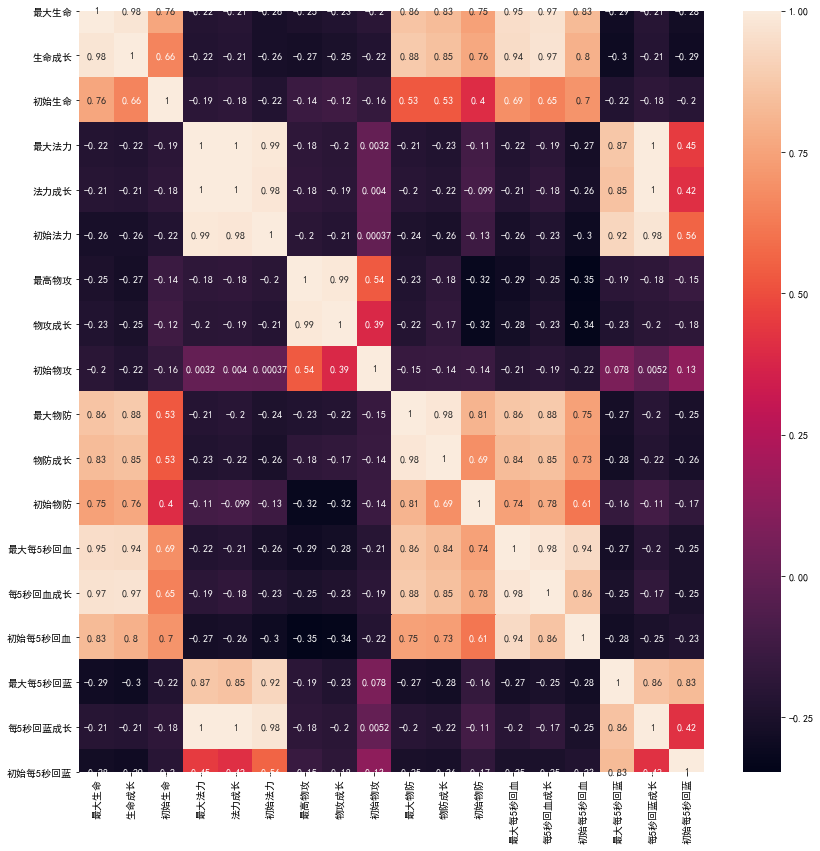

[ 0 12  9 20  4  4  1  9  6 14 13 12 20 17 16 13  0  6 26 28  7  3 28  3
  3  3 28 21  5 25 17 25 25  5 25 25  5 22 27  2 25  5  5 25  5  2 29 27
 12  5  8 24 26 11 11  0 23 24 18  4 23 26 15  0 19 24 10 24 21]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# -*- coding:utf-8 -*-
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
# 使用GMM高斯混合模型进行聚类
from sklearn.mixture import GaussianMixture
# 使用标准化正态分布进行数据规范化
from sklearn.preprocessing import StandardScaler

# 数据加载，避免中文乱码问题
data_ori = pd.read_csv('./heros.csv', encoding='gb18030')
# 特征值选择
features = [u'最大生命',u'生命成长',u'初始生命',u'最大法力',u'法力成长',u'初始法力',u'最高物攻',
            u'物攻成长',u'初始物攻',u'最大物防',u'物防成长',u'初始物防',u'最大每5秒回血',u'每5秒回血成长',
            u'初始每5秒回血',u'最大每5秒回蓝',u'每5秒回蓝成长',u'初始每5秒回蓝',u'最大攻速',u'攻击范围']
# 选取特征值数据
data = data_ori[features]

# 对英雄属性之间的关系进行可视化
# 设置plt正确显示中文，
plt.rcParams['font.sans-serif'] = ['simhei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
# 使用热力图来进行显示features_mean 字段之间的相关性
corr = data[features].corr()
plt.figure(figsize=(14,14))
# annot=True 显示每个方格的数据
sns.heatmap(corr, annot=True)
plt.show(sns)

# 相关性大的属性保留一个，因此可以对属性进行降维
features_remain = [u'最大生命',u'生命成长',u'初始生命',u'最大法力',u'法力成长',u'初始法力',u'最高物攻',
            u'物攻成长',u'初始物攻',u'最大物防',u'物防成长',u'初始物防',u'最大每5秒回血',u'每5秒回血成长',
            u'初始每5秒回血',u'最大每5秒回蓝',u'每5秒回蓝成长',u'初始每5秒回蓝',u'最大攻速',u'攻击范围']
data = data_ori[features_remain]
# 处理最大攻速的百分号和攻击范围的近程和远程
# 这列会产生一个使用链式索引的警告:https://www.jianshu.com/p/72274ccb647a
data[u'最大攻速'] = data[u'最大攻速'].apply(lambda x: float(x.strip('%'))/100)
data[u'攻击范围'] = data[u'攻击范围'].map({'远程':1,'近战':0})
# 采用Z-Score规范化数据，保证每个特征维度的数据均值为0，方差为1
ss = StandardScaler()
data = ss.fit_transform(data)
# 构造 GMM 聚类
gmm = GaussianMixture(n_components=30, covariance_type='full')
gmm.fit(data)
# 训练数据
prediction = gmm.predict(data)
print(prediction)
# 将分组结果输出到CSV文件中
data_ori.insert(0, '分组', prediction)
data_ori.to_csv('./hero_allfeatures_out.csv', index=False, sep=',', encoding='gb18030')

2、使用Calinski_Harabaz进行平分，分别使用聚类个数为3和30：

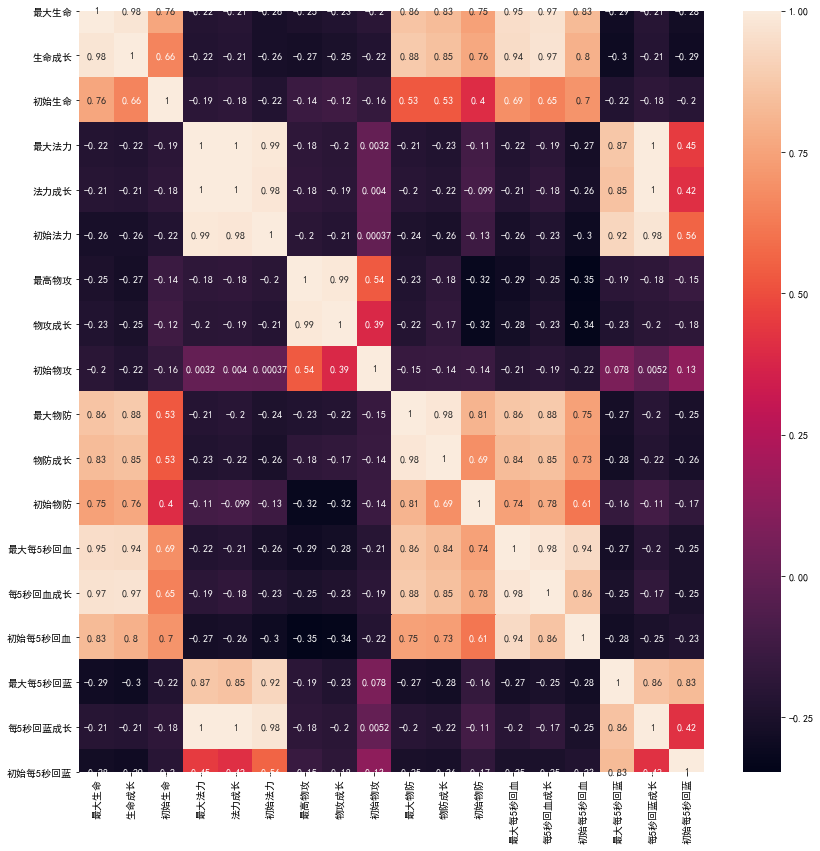

[14 19 11 25 13 13 17 11  8  2  4 20 25 19 23  4 26  8  3 24 21  0 24  0
  0  0 24 29  7 15 19 15 15  7 15 15  6  9 12  1 15  6  7 15  7  1 20 12
 20  7 16  5  3 10 10 14 18  5 28 13 18  3 22 14 27  5  5  5 29]
聚类个数为30的评分:21.015731243251988 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


In [25]:
# -*- coding:utf-8 -*-
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
# 使用GMM高斯混合模型进行聚类
from sklearn.mixture import GaussianMixture
# 使用标准化正态分布进行数据规范化
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabaz_score

# 数据加载，避免中文乱码问题
data_ori = pd.read_csv('./heros.csv', encoding='gb18030')
# 特征值选择
features = [u'最大生命',u'生命成长',u'初始生命',u'最大法力',u'法力成长',u'初始法力',u'最高物攻',
            u'物攻成长',u'初始物攻',u'最大物防',u'物防成长',u'初始物防',u'最大每5秒回血',u'每5秒回血成长',
            u'初始每5秒回血',u'最大每5秒回蓝',u'每5秒回蓝成长',u'初始每5秒回蓝',u'最大攻速',u'攻击范围']
# 选取特征值数据
data = data_ori[features]

# 对英雄属性之间的关系进行可视化
# 设置plt正确显示中文，
plt.rcParams['font.sans-serif'] = ['simhei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
# 使用热力图来进行显示features_mean 字段之间的相关性
corr = data[features].corr()
plt.figure(figsize=(14,14))
# annot=True 显示每个方格的数据
sns.heatmap(corr, annot=True)
plt.show(sns)

# 相关性大的属性保留一个，因此可以对属性进行降维
features_remain = [u'最大生命',u'初始生命',u'最大法力',u'最高物攻',
            u'初始物攻',u'最大物防',u'初始物防',u'最大每5秒回血',
            u'最大每5秒回蓝',u'初始每5秒回蓝',u'最大攻速',u'攻击范围']
data = data_ori[features_remain]
# 处理最大攻速的百分号和攻击范围的近程和远程
# 这列会产生一个使用链式索引的警告:https://www.jianshu.com/p/72274ccb647a
data[u'最大攻速'] = data[u'最大攻速'].apply(lambda x: float(x.strip('%'))/100)
data[u'攻击范围'] = data[u'攻击范围'].map({'远程':1,'近战':0})
# 采用Z-Score规范化数据，保证每个特征维度的数据均值为0，方差为1
ss = StandardScaler()
data = ss.fit_transform(data)
# 构造 GMM 聚类
gmm = GaussianMixture(n_components=30, covariance_type='full')
gmm.fit(data)
# 训练数据
prediction = gmm.predict(data)
print(prediction)
# 将分组结果输出到CSV文件中
data_ori.insert(0, '分组', prediction)
data_ori.to_csv('./hero_out.csv', index=False, sep=',', encoding='gb18030')
print('聚类个数为30的评分:{} '.format(calinski_harabaz_score(data, prediction)))


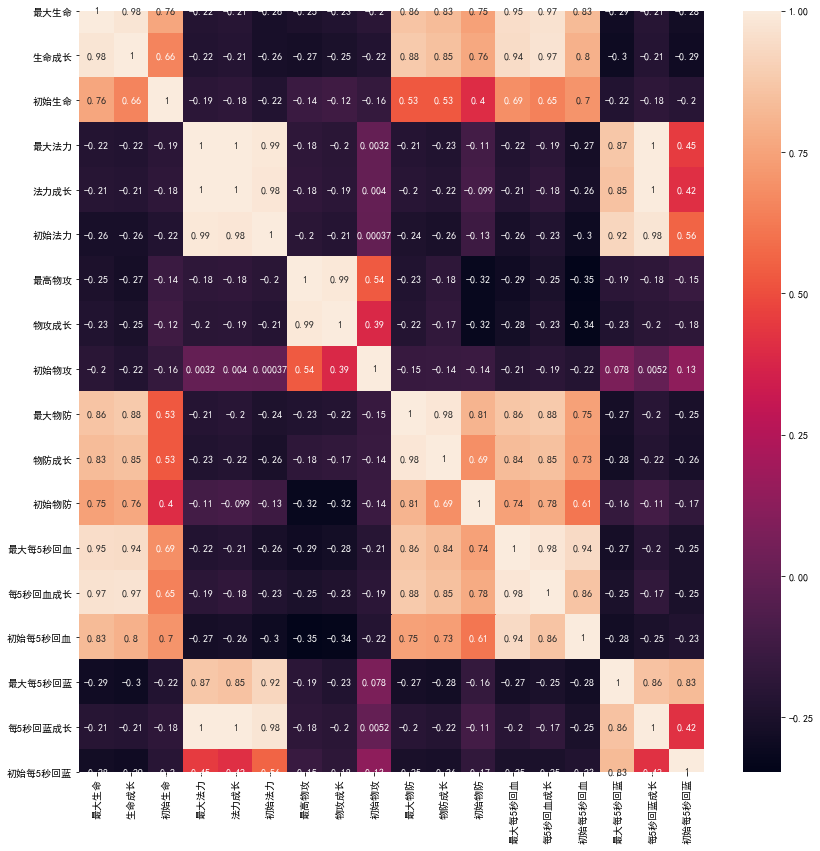

[2 2 1 1 0 0 0 1 1 2 1 2 1 2 1 1 2 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 0 2 0 0 2 0 2 2 2 2]
聚类个数为3的评分:24.793874699417668 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


In [24]:
# -*- coding:utf-8 -*-
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
# 使用GMM高斯混合模型进行聚类
from sklearn.mixture import GaussianMixture
# 使用标准化正态分布进行数据规范化
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabaz_score

# 数据加载，避免中文乱码问题
data_ori = pd.read_csv('./heros.csv', encoding='gb18030')
# 特征值选择
features = [u'最大生命',u'生命成长',u'初始生命',u'最大法力',u'法力成长',u'初始法力',u'最高物攻',
            u'物攻成长',u'初始物攻',u'最大物防',u'物防成长',u'初始物防',u'最大每5秒回血',u'每5秒回血成长',
            u'初始每5秒回血',u'最大每5秒回蓝',u'每5秒回蓝成长',u'初始每5秒回蓝',u'最大攻速',u'攻击范围']
# 选取特征值数据
data = data_ori[features]

# 对英雄属性之间的关系进行可视化
# 设置plt正确显示中文，
plt.rcParams['font.sans-serif'] = ['simhei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
# 使用热力图来进行显示features_mean 字段之间的相关性
corr = data[features].corr()
plt.figure(figsize=(14,14))
# annot=True 显示每个方格的数据
sns.heatmap(corr, annot=True)
plt.show(sns)

# 相关性大的属性保留一个，因此可以对属性进行降维
features_remain = [u'最大生命',u'初始生命',u'最大法力',u'最高物攻',
            u'初始物攻',u'最大物防',u'初始物防',u'最大每5秒回血',
            u'最大每5秒回蓝',u'初始每5秒回蓝',u'最大攻速',u'攻击范围']
data = data_ori[features_remain]
# 处理最大攻速的百分号和攻击范围的近程和远程
# 这列会产生一个使用链式索引的警告:https://www.jianshu.com/p/72274ccb647a
data[u'最大攻速'] = data[u'最大攻速'].apply(lambda x: float(x.strip('%'))/100)
data[u'攻击范围'] = data[u'攻击范围'].map({'远程':1,'近战':0})
# 采用Z-Score规范化数据，保证每个特征维度的数据均值为0，方差为1
ss = StandardScaler()
data = ss.fit_transform(data)
# 构造 GMM 聚类
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(data)
# 训练数据
prediction = gmm.predict(data)
print(prediction)
# 将分组结果输出到CSV文件中
data_ori.insert(0, '分组', prediction)
data_ori.to_csv('./hero_3_out.csv', index=False, sep=',', encoding='gb18030')
print('聚类个数为3的评分:{} '.format(calinski_harabaz_score(data, prediction)))
